# Vehicle Detection Project

The goals / steps of this project are the following:

Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
Estimate a bounding box for vehicles detected.


In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

## Histogram of Oriented Gradients (HOG)
### 1. Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.
I started by reading in all the vehicle and non-vehicle images.

In [2]:
cars = glob.glob('dataset/vehicles/**/*.png')
notcars = glob.glob('dataset/non-vehicles/**/*.png')
print(len(cars), len(notcars))

8792 8968


Here is an example of one of each of the vehicle and non-vehicle classes:

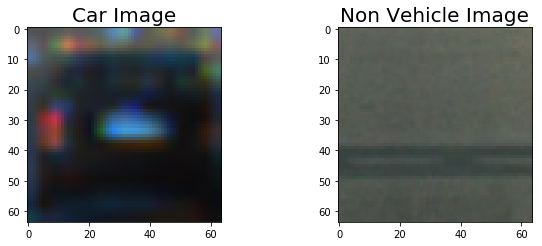

In [3]:
rand = np.random.randint(0, 1000)
car_img  = mpimg.imread(cars[rand])
not_car_img = mpimg.imread(notcars[rand])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
f.tight_layout()
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(not_car_img)
ax2.set_title('Non Vehicle Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

I then explored different color spaces and different skimage.hog() parameters (orientations, pixels_per_cell, and cells_per_block). I grabbed random images from each of the two classes and displayed them to get a feel for what the skimage.hog() output looks like.

Following cell contains the code that will do HOG based feature extraction

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Following result shows HOG features extracted from vehicle and non-vehicle images using the HOG parameters of orientations=8, pixels_per_cell=(8, 8) and cells_per_block=(2, 2):

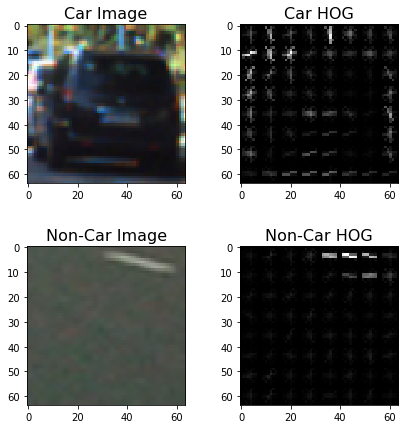

In [6]:
car_img = mpimg.imread(cars[5])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(notcars[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

1b. How I settled on final choice of HOG parameters.
I tried various combinations of parameters and evaluated for their performace through test set and run them on the video. Most of the parameters failed for proper detection of cars or detecting too many false positives. I assume there is no standard apparoach, I varied individual parameter at a time and evaluated performace. As the number of parameters is immense it is impossible to try all the possible combinations. The main things that I tried are changing color spaces, channel hog features, orientation.

### 2. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

The SVC classifier is trained with features extracted using HOG in YCrCb colour space.

Following function will extract the HOG features.

In [7]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [10]:
# Feature extraction parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

44.36 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


Following code is used for training SVC classifier.

In [11]:
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Sliding Window Search

### 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

The function 'find_cars()in the following cell takes in image, scale and start and y positions to search a regon for cars. Multiple scale, y_start_stop values are used to cover the image in a sensible and general way to detect vehicle in any road. This code is adapted from lesson material.

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

### Sample result

In [13]:

test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

5 rectangles found in image


In [14]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

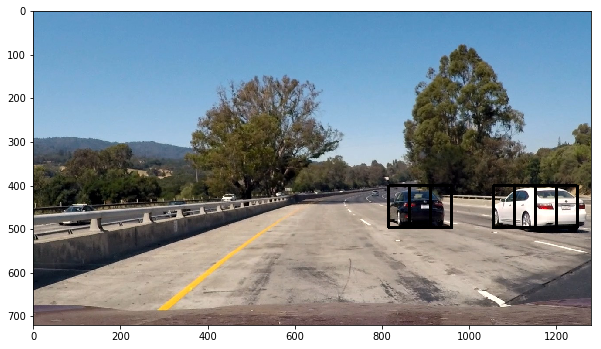

In [15]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Following code shows one sample ystart and ystop search space. Like this I have used five combinations to cover entire image for detecting vehicle.

Number of boxes:  78


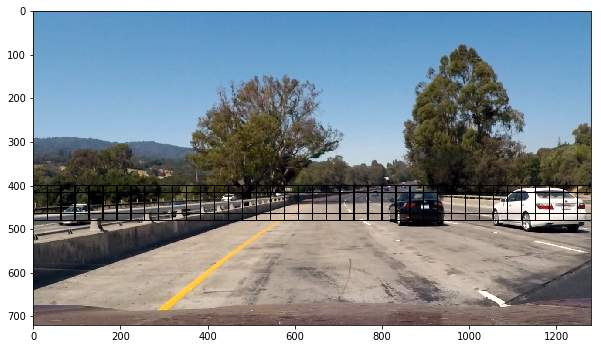

In [16]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### 2. Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

Using multiscale search space selection along with HOG feature detection in YCrCb 3-channel space provided faster and better result. Following is one sample result. 

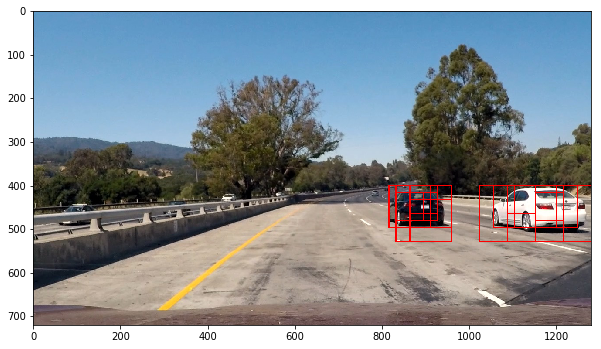

In [17]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

yss = [[400,464],[416,480],[400,496],[432,528],[400,528],[432,560],[400,596],[464,660]]
scl = [1.0,1.0,1.5,1.5,2,2,3.5,3.5]

for i in range(len(scl)) :
    scale = scl[i]
    ystart =yss[i][0]
    ystop =yss[i][1]
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color=(255,0,0), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Heat map based false positive reduction

Following is the function for heat map creation.

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

#### Test output of the heatmap

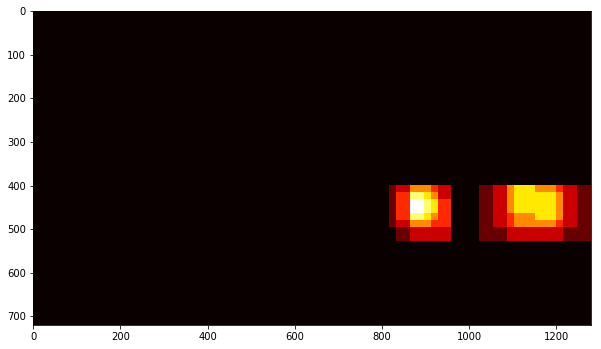

In [19]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

#### Function for applying threshold to heat map

In [20]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#### Sample result after thresholding

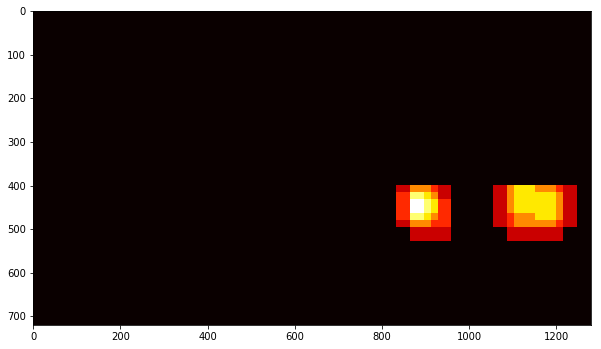

In [21]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

#### Sample result after blob detection

2 cars found


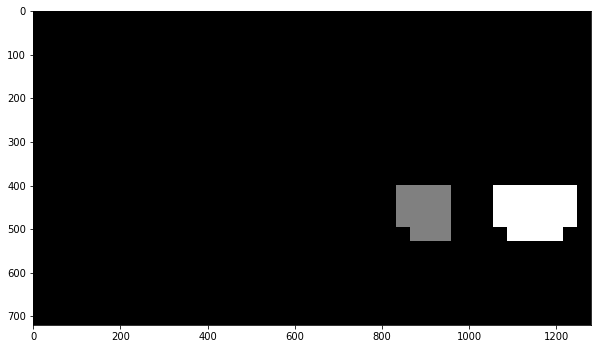

In [22]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

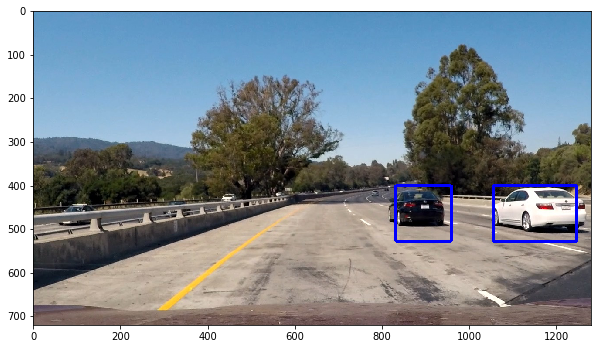

In [23]:

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [24]:
yss = [[400,464],[416,480],[400,496],[432,528],[400,528],[432,560],[400,596],[464,660]]
scl = [1.0,1.0,1.5,1.5,2,2,3.5,3.5]

In [25]:
def process_frame(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    for i in range(len(scl)) :
            scale = scl[i]
            ystart =yss[i][0]
            ystop =yss[i][1]
            rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
    
    

### Sample result after testing the process_frame function on different test images. 

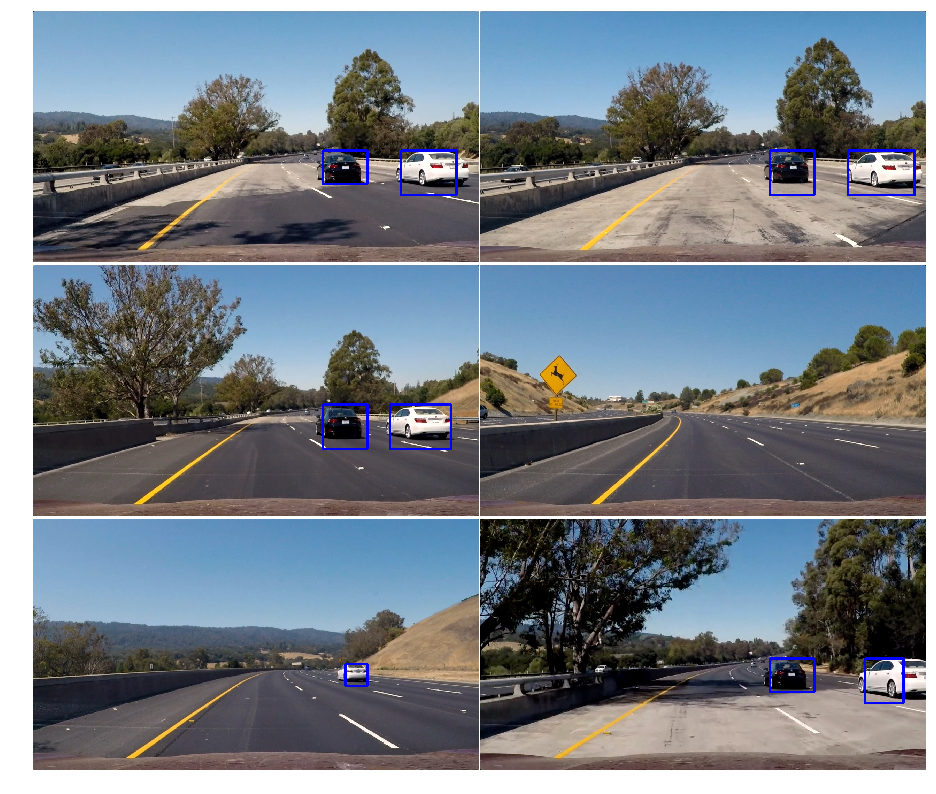

In [26]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

### Code to generate the resultant video

In [27]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [04:46<00:00,  4.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 5min 31s, sys: 19.8 s, total: 5min 51s
Wall time: 4min 47s


## Video Implementation

### 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

My final video is provided below.
#### Here's a [link to the video result](./project_video_out.mp4) in case the html interface is not working.

In [28]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="project_video_out.mp4" type="video/mp4">
</video></div>""")

### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

Some sample results and based on algorithm flow to reduce false positive are given under the Heat map based false positive reduction section.

## Discussion

### 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

The main difficulties faced in implementing the pipeline are choosing the right feature set and tuning the parameters for right output. As the system contains multiple steps and parameters tunable at each step, it's leading to hundreds of combinations and most of them turning bad at the end even through providing good results initially or on samples. There are even now some false positives and no detections for certain times, this are failures. The model needs further training and testing.

I built the pipleine based on the modules of code prepared during the assignments, tweaking one parameter at a time to check the result and using the combinations working best. I would train the model with more data, choose a model which could do better than this. The model performs way to slow at 1 frame per second which could never be employed in real time scenarios and needs a great amount of optimization for using in the vehicle directly. Inclusion of tracking will reduce the true negatives in the result